In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import sys, os
from model.EDA.gu.code.utils import *

sys.path.append('/Users/admin/Desktop/softeer-team-project/EDA/gu/code')

DATA_DIR = "../EDA/gu/data"

# Modling (Hot Posts / Cold Posts)

In [2]:
events = ["벤츠 화재", "아이오닉 누수", "아이오닉 iccu", "코나 화재"]
communities = ['clien', 'bobae', 'fmkorea', 'naver_cafe']

In [3]:

# load dataset with full comments info
per_event_comment_dfs = []
for event in events:
    per_community_dfs = []
    for community in communities:
        comments_df = pd.read_csv(f'{DATA_DIR}/{event}/{community}_comments.csv') 
        comments_df.cmt_created_at = comments_df.cmt_created_at.apply(parse_dates)
        if community=='clien':
            comments_df.columns = ['cmt_author', 'cmt_count', 'post_id', 'cmt_created_at']
        per_community_dfs.append(comments_df)
    per_event_comment_df = pd.concat(per_community_dfs)
    per_event_comment_dfs.append(per_event_comment_df)
all_comments_df = pd.concat(per_event_comment_dfs)

In [4]:
# Load Dataset
hot_posts_df = pd.read_csv(f'{DATA_DIR}/splitted/hot_posts.csv')
hot_df = pd.merge(hot_posts_df, all_comments_df, left_on='id', right_on='post_id', how='left')

cold_posts_df = pd.read_csv(f'{DATA_DIR}/splitted/cold_posts.csv')
cold_df = pd.merge(cold_posts_df, all_comments_df, left_on='id', right_on='post_id', how='left')


In [5]:
# preprocessing
hot_df = hot_df.dropna(subset=['created_at']) # 생성 시간이 없는 게시물 제거
hot_df.views = hot_df.views.map(str).apply(remove_commna).apply(convert_str_to_int)
hot_df.likes = hot_df.likes.map(str).apply(remove_commna).apply(convert_str_to_float)
hot_df.created_at = hot_df.created_at.apply(parse_dates)

cold_df = cold_df.dropna(subset=['created_at']) # 생성 시간이 없는 게시물 제거
cold_df.views = cold_df.views.map(str).apply(remove_commna).apply(convert_str_to_int)
cold_df.likes = cold_df.likes.map(str).apply(remove_commna).apply(convert_str_to_float)
cold_df.created_at = cold_df.created_at.apply(parse_dates)

In [6]:
# Make column for relative time
time_interval = 5*60 # seconds
max_rel_time = (12*60*60 / time_interval) + 1 # 최근 12시간만 확인

hot_df['relative_time'] =  hot_df['cmt_created_at'] - hot_df['created_at']
hot_df['relative_time'] = hot_df['relative_time'].apply(timedelta_to_seconds) // time_interval # applying binnig (30 minutes)
hot_df = hot_df[hot_df['relative_time'] <= max_rel_time]

cold_df['relative_time'] =  cold_df['cmt_created_at'] - cold_df['created_at']
cold_df['relative_time'] = cold_df['relative_time'].apply(timedelta_to_seconds) // time_interval # applying binnig (30 minutes)
cold_df = cold_df[cold_df['relative_time'] <= max_rel_time]

In [7]:
hot_model_df = hot_df[['id', 'relative_time']]
cold_model_df = cold_df[['id', 'relative_time']]

In [8]:
pdf_dfs = []

for i in range(145):
    # for i in range(144):
    hot_model_interval_df = hot_model_df[hot_model_df['relative_time']<=i].groupby('id').agg(['count'])
    hot_model_interval_df.columns = hot_model_interval_df.columns.droplevel(0)
    hot_model_interval_df.columns = ['count']

    cold_model_interval_df = cold_model_df[cold_model_df['relative_time']<=i].groupby('id').agg(['count'])
    cold_model_interval_df.columns = cold_model_interval_df.columns.droplevel(0)
    cold_model_interval_df.columns = ['count']

    x_values = np.arange(0, 200)

    mean_hot = hot_model_interval_df['count'].mean()
    std_hot = hot_model_interval_df['count'].std()
    hot_pdf_values = stats.norm.pdf(x_values, mean_hot, std_hot)
    hot_pdf_df = pd.DataFrame(hot_pdf_values, columns=['pdf'])
    hot_pdf_df['cumulative_num'] = x_values
    hot_pdf_df['post_type'] = 1
    hot_pdf_df['relative_time'] = int(i*5)

    mean_cold = cold_model_interval_df['count'].mean()
    std_cold = cold_model_interval_df['count'].std()
    cold_pdf_values = stats.norm.pdf(x_values, mean_cold, std_cold)
    cold_pdf_df = pd.DataFrame(cold_pdf_values, columns=['pdf'])
    cold_pdf_df['cumulative_num'] = x_values
    cold_pdf_df['post_type'] = 0
    cold_pdf_df['relative_time'] = int(i*5)

    pdf_dfs.append(hot_pdf_df)
    pdf_dfs.append(cold_pdf_df)
    
model_df = pd.concat(pdf_dfs).reset_index()

In [9]:
model_df.to_csv("model_result.csv", index=False)

## Result Visualize

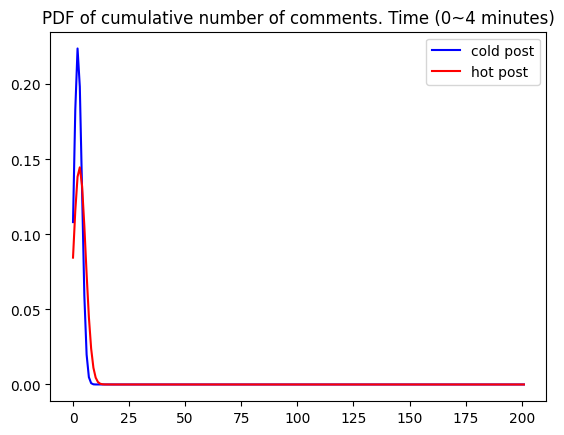

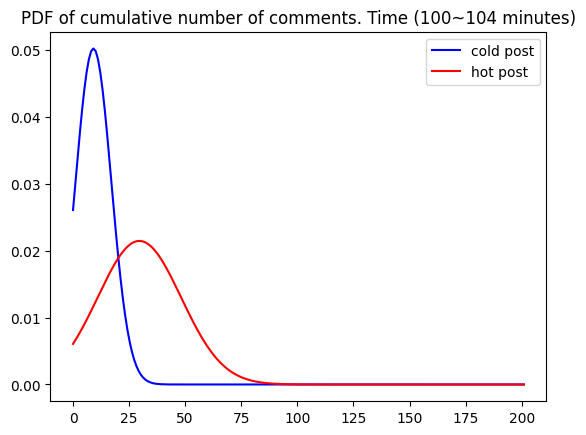

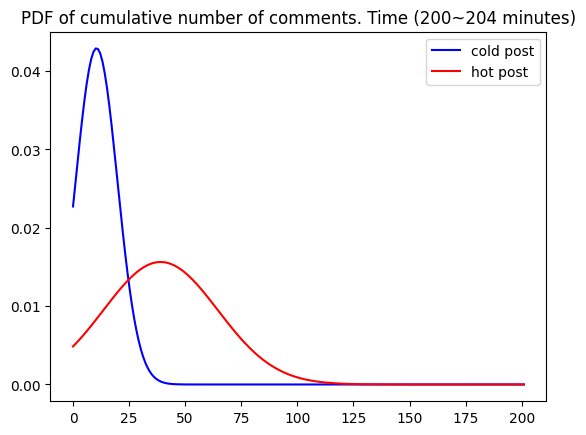

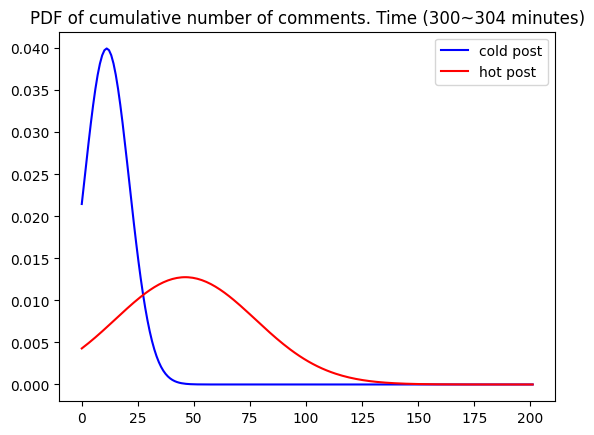

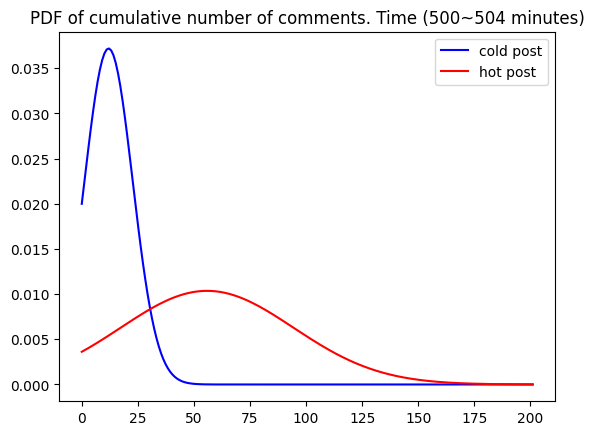

In [12]:
# time_interval별로 PDF를 시각화
visualize_model(hot_model_df, cold_model_df, 0)
visualize_model(hot_model_df, cold_model_df, 20)
visualize_model(hot_model_df, cold_model_df, 40)
visualize_model(hot_model_df, cold_model_df, 60)
visualize_model(hot_model_df, cold_model_df, 100)